In [1]:
%load_ext autoreload
%autoreload 2

# Unexpected Examples, e.g., Adversarial Examples

Tree ensembles can behave erratically for unexpected examples.

Tree ensembles are susceptible to evasion attacks. An evasion attack constructs an adversarial example specifically designed to fool the ensemble to make the wrong prediction.

## Preliminaries

In [2]:
import time
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np

import veritas
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## The MNIST dataset of handwritten digits

We use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).

In [3]:
X_mc, y_mc = datasets.fetch_openml(data_id=554, return_X_y=True, as_frame=False)

We construct a binary classification task by contrasting 2 and 8.

In [4]:
class0, class1 = '2', '8'
mask = (y_mc == class0) | (y_mc == class1)
X = X_mc[mask, :].astype(veritas.FloatT)
yn = y_mc[mask]
y = yn == class1

Use a train and test set.

In [5]:
xtrain, xtest, ytrain, ytest, ytrain_n, ytest_n = train_test_split(X, y, yn, test_size=0.2, shuffle=True, random_state=13)

## Train the classifier

In [6]:
params = {
    "n_estimators": 20,
    "eval_metric": "error",
    
    "tree_method": "hist",
    "seed": 135,
    "max_depth": 4,
    "learning_rate": 0.4
}
model = xgb.XGBClassifier(**params)

t = time.time()
model.fit(X, y)
print(f"XGB trained in {time.time()-t} seconds")

XGB trained in 0.623908281326294 seconds


In [7]:
ytrain_pred = model.predict(xtrain)
ytest_pred = model.predict(xtest)
acc_train = accuracy_score(ytrain, ytrain_pred)
acc_test = accuracy_score(ytest, ytest_pred)

print(f"Train acc: {acc_train:.3f}, test acc: {acc_test:.3f} wrt true labels")

Train acc: 0.996, test acc: 0.995 wrt true labels


# Generate adversarial examples

In [8]:
# FROM CLASS 0 -> CLASS 1
number_of_adv_examples = 6

rng = np.random.default_rng(seed=159)
subset = rng.choice(range(xtest.shape[0]), number_of_adv_examples)

eps = 50

def noticks(ax):
    for x in ax:
        x.set_xticks([])
        x.set_yticks([])

In [9]:
at = veritas.get_addtree(model)


| XGBOOST's base_score
|   base_score diff std      8.999774135166457e-08 OK
|   base_score reported      0.4940285
|   versus manually detected -0.023887091157375834
|   abs err                  0.5179155911573758
|   rel err                  1.048351646023207
|   (!) base_score NOT THE SAME with relative tolerance 0.0002



true_label=2, objective=MAX_OUTPUT done in 0.36ms
    RAW:  -4.2180 -> 6.7231
          -4.2180 -> 6.7231
    PROB: 0.0145 -> 0.9988
          0.0145 -> 0.9988


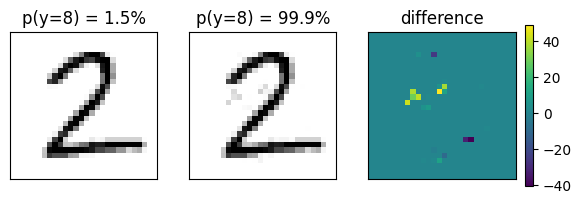


true_label=8, objective=MIN_OUTPUT done in 0.44ms
    RAW:  4.9177 -> -1.8366
          4.9177 -> -1.8366
    PROB: 0.9927 -> 0.1375
          0.9927 -> 0.1375


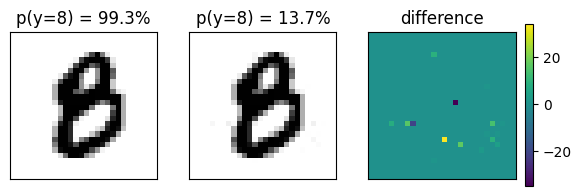


true_label=8, objective=MIN_OUTPUT done in 0.38ms
    RAW:  6.0362 -> -2.8642
          6.0362 -> -2.8642
    PROB: 0.9976 -> 0.0540
          0.9976 -> 0.0540


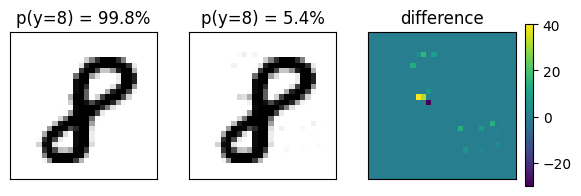


true_label=2, objective=MAX_OUTPUT done in 0.35ms
    RAW:  -4.8124 -> 6.4438
          -4.8124 -> 6.4438
    PROB: 0.0081 -> 0.9984
          0.0081 -> 0.9984


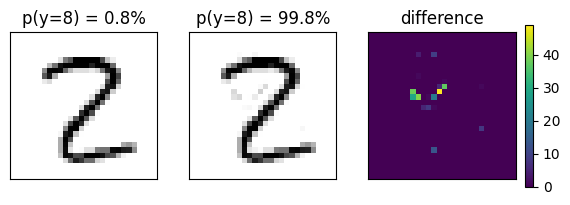


true_label=2, objective=MAX_OUTPUT done in 0.34ms
    RAW:  -3.3363 -> 7.3444
          -3.3363 -> 7.3444
    PROB: 0.0343 -> 0.9994
          0.0343 -> 0.9994


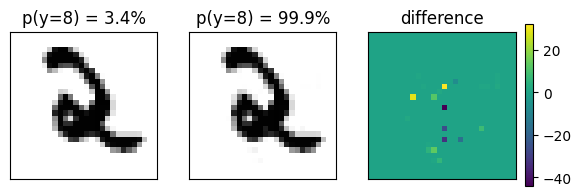


true_label=2, objective=MAX_OUTPUT done in 0.55ms
    RAW:  -4.2530 -> 7.6476
          -4.2530 -> 7.6476
    PROB: 0.0140 -> 0.9995
          0.0140 -> 0.9995


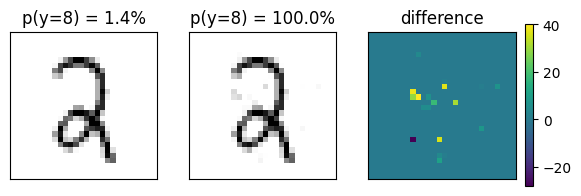

In [10]:
for i in subset:
    base_example = xtest[i, :]
    true_label = ytest_n[i]

    heur = veritas.HeuristicType.MAX_OUTPUT if true_label == class0 \
           else veritas.HeuristicType.MIN_OUTPUT

    config = veritas.Config(heur)
    config.ignore_state_when_worse_than = 0.0

    prune_box = [veritas.Interval(max(0.0, x-eps), min(255, x+eps)) for x in base_example]
    search = config.get_search(at, prune_box)

    tstart = time.time()
    while search.num_solutions() == 0:
        if search.steps(100) == veritas.StopReason.NO_MORE_OPEN:
            break
    tstop = time.time()

    print(f"true_label={true_label}, objective={str(heur)[14:]}",
          f"done in {1000*(tstop-tstart):.2f}ms")

    if search.num_solutions() > 0:
        sol = search.get_solution(0)
        adv_example = veritas.get_closest_example(sol, base_example, eps=1e-3)

        # raw scores
        base_pred_at = at.eval(np.atleast_2d(base_example))[0,0]
        base_pred = model.predict(np.atleast_2d(base_example), output_margin=True)[0]
        adv_pred = model.predict(np.atleast_2d(adv_example), output_margin=True)[0]
        adv_pred_at = at.eval(np.atleast_2d(adv_example))[0,0]

        print(f"    RAW:  {base_pred_at:.4f} -> {adv_pred_at:.4f}")
        print(f"          {base_pred:.4f} -> {adv_pred:.4f}")
        
        # probabilities
        base_prob_at = at.predict(np.atleast_2d(base_example))[0,0]
        base_prob = model.predict_proba(np.atleast_2d(base_example))[0,1]
        adv_prob = model.predict_proba(np.atleast_2d(adv_example))[0,1]
        adv_prob_at = at.predict(np.atleast_2d(adv_example))[0,0]
        
        print(f"    PROB: {base_prob_at:.4f} -> {adv_prob_at:.4f}")
        print(f"          {base_prob:.4f} -> {adv_prob:.4f}")

        fig, ax = plt.subplots(1, 3, figsize=(7, 2.1), width_ratios=[1, 1, 1.25])
        noticks(ax)
        
        ax[0].imshow((base_example).reshape((28,28)), cmap="binary")
        ax[0].set_title(f"p(y={class1}) = {base_prob*100:.1f}%")
        ax[1].imshow((adv_example).reshape((28,28)), cmap="binary")
        ax[1].set_title(f"p(y={class1}) = {adv_prob*100:.1f}%")
        imdiff = ax[2].imshow((adv_example-base_example).reshape((28,28)))
        ax[2].set_title(f"difference")
        fig.colorbar(imdiff, cax=None)
        plt.show()
    else:
        print("no adversarial examples found for", i)
    print()


## An alternative verification question:

Can an image that only has a narrow non-black band in the middle ever get the negative class?

Veritas generated an example in 0.47ms, stop_reason=StopReason.NONE
AddTreeType.CLF_SOFTMAX


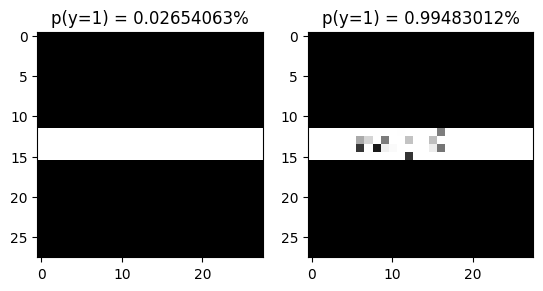

In [11]:
blackband = np.zeros(28*28)
blackband[0:28*12] = 255.0
blackband[28*16:] = 255.0

anything = veritas.Interval(0.0, 255.0)
black = veritas.Interval.constant(255.0)

config = veritas.Config(veritas.HeuristicType.MAX_OUTPUT)
config.ignore_state_when_worse_than = 0.0

prune_box = [black if x>0 else anything for x in blackband]
search = config.get_search(at, prune_box)

tstart = time.time()
while search.num_solutions() == 0:
    stop_reason = search.steps(100)
    if stop_reason == veritas.StopReason.NO_MORE_OPEN:
        break
tstop = time.time()

print(f"Veritas generated an example in {1000*(tstop-tstart):.2f}ms, stop_reason={stop_reason}")

sol = search.get_solution(0)
generated = veritas.get_closest_example(sol, blackband, eps=1e-3)

print(at.get_type())

prob_blackband = at.predict(blackband)[0,0]
prob_generated = at.predict(generated)[0,0]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(blackband.reshape((28, 28)), cmap="binary")
ax[0].set_title(f"p(y=1) = {prob_blackband:.8f}%")
ax[1].imshow(generated.reshape((28, 28)), cmap="binary")
ax[1].set_title(f"p(y=1) = {prob_generated:.8f}%")
plt.show()


## Another alternative

Can we find a positive example with non-white pixels only in the top 10 rows of pixels?

Veritas generated an example in 0.08ms, stop_reason=StopReason.OPTIMAL


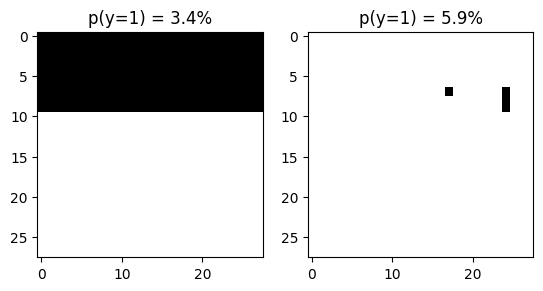

We proved that no such example exists!


In [12]:
allwhite = np.zeros(28*28)
whiteband = np.zeros(28*28)
whiteband[0:28*10] = 255.0

anything = veritas.Interval(0.0, 255.0)
white = veritas.Interval.constant(0.0)

config = veritas.Config(veritas.HeuristicType.MAX_OUTPUT)
#config.ignore_state_when_worse_than = 0.0

prune_box = [anything if x>0 else white for x in whiteband]
search = config.get_search(at, prune_box)

tstart = time.time()
while search.num_solutions() == 0:
    stop_reason = search.steps(100)
    if stop_reason == veritas.StopReason.NO_MORE_OPEN:
        break
tstop = time.time()

print(f"Veritas generated an example in {1000*(tstop-tstart):.2f}ms,",
      f"stop_reason={stop_reason}")

if search.num_solutions() > 0:
    sol = search.get_solution(0)
    generated = veritas.get_closest_example(sol, allwhite, eps=1e-3)
    
    prob_whiteband = at.predict(whiteband)[0,0]
    prob_generated = at.predict(generated)[0,0]
    
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(whiteband.reshape((28, 28)), cmap="binary")
    ax[0].set_title(f"p(y=1) = {prob_whiteband*100:.1f}%")
    ax[1].imshow(generated.reshape((28, 28)), cmap="binary")
    ax[1].set_title(f"p(y=1) = {prob_generated*100:.1f}%")
    plt.show()
    
if search.num_solutions() == 0 or stop_reason == veritas.StopReason.OPTIMAL \
        and prob_generated < 0.5:
    print("We proved that no such example exists!")